## Implementación de un clasificador de estilo de ajedrez usando redes neuronales

# Instalación de dependencias

In [ ]:
!pip install tensorflow imbalanced-learn joblib python-chess chardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=fecc6e973b464ce1e3de2a3fc031ab7e0e83cdc8abfce5166725ae8a17b32286
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


# Importación de librerías

In [ ]:
import chess
import chess.pgn
import io
import chardet
import numpy as np
import joblib
from google.colab import files
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# Clase principal del analizador

In [ ]:
class ChessStyleAnalyzer:
    def __init__(self):

        # Mapeos de estilos
        self.style_mapping = {
            'Steinitz, Wilhelm': 'positional',
            'Capablanca, José': 'positional',
            'Karpov, Anatoly': 'positional',
            'Kramnik, Vladimir': 'positional',
            'Alekhine, Alexander': 'combinative',
            'Fischer, Robert James': 'combinative',
            'Kasparov, Garry': 'combinative',
            'Tal, Mikhail': 'combinative',
            'Petrosian, Tigran': 'positional',
            'Lasker, Emanuel': 'universal',
            'Spassky, Boris': 'universal',
            'Anand, Viswanathan': 'universal',
            'Carlsen, Magnus': 'universal',
            'Botvinnik, Mikhail': 'positional',
            'Euwe, Max': 'positional'
        }

        # Calcular número de clases únicas
        self.unique_styles = list(set(self.style_mapping.values()))
        self.num_classes = len(self.unique_styles)

        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.unique_styles)
        self.model = self._build_neural_network()

        self.opening_mapping = {
            'positional': [
                ('E00', 'Apertura Catalana'),
                ('A10', 'Apertura Inglesa'),
                ('D02', 'Sistema Londres')
            ],
            'combinative': [
                ('C39', 'Gambito de Rey'),
                ('C44', 'Apertura Escocesa'),
                ('C21', 'Gambito Danés')
            ],
            'universal': [
                ('C50', 'Apertura Italiana'),
                ('C60', 'Apertura Española'),
                ('D00', 'Gambito de Dama')
            ]
        }

        self.style_spanish_mapping = {
            'positional' : 'Posicional',
            'combinative' : 'Combinativo',
            'universal' : 'Universal'
        }

    def _build_neural_network(self):
        model = Sequential([
            Dense(512, activation='relu', input_shape=(840,), kernel_regularizer=l2(0.001)),
            Dropout(0.6),
            Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
            Dropout(0.5),
            Dense(128, activation='relu', kernel_regularizer=l2(0.0003)),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def process_pgns(self):
        """Procesa archivos PGN subidos y extrae características"""
        uploaded = files.upload()
        features = []
        labels = []

        for filename, content in uploaded.items():
            try:
                # Detección de codificación
                enc = chardet.detect(content)['encoding'] or 'latin-1'
                pgn_text = content.decode(enc, errors='replace')
                pgn = io.StringIO(pgn_text)

                while True:
                    game = chess.pgn.read_game(pgn)
                    if not game:
                        break

                    # Obtener estilo del jugador
                    white = game.headers.get('White', '').strip()
                    black = game.headers.get('Black', '').strip()
                    style = self.style_mapping.get(white) or self.style_mapping.get(black)

                    if style:
                        game_features = self._extract_game_features(game)
                        if game_features:
                            features.append(game_features)
                            labels.append(style)

            except Exception as e:
                print(f"Error procesando {filename}: {str(e)}")
                continue

        if not features:
            print("No hay datos válidos para entrenar")
            return False

        # Asegurar que el LabelEncoder se ajuste correctamente
        self.label_encoder.fit(list(set(self.style_mapping.values())))  # Forzar todas las clases

        # Preprocesamiento
        self.y = self.label_encoder.fit_transform(labels)
        self.X = self.scaler.fit_transform(features)

        # Balancear datos
        adasyn = ADASYN(n_neighbors=4)
        self.X, self.y = adasyn.fit_resample(self.X, self.y)

        print(f"\nDatos procesados: {len(self.X)} partidas")
        print("Distribución de estilos:", dict(zip(
            self.label_encoder.inverse_transform(np.unique(self.y)),
            np.bincount(self.y)
        )))
        return True

    def _extract_game_features(self, game):
      """Extrae características avanzadas de una partida de ajedrez"""
      MOVES_TO_ANALYZE = 60
      FEATURES_PER_MOVE = 14
      TOTAL_FEATURES = MOVES_TO_ANALYZE * FEATURES_PER_MOVE

      board = game.board()
      features = []
      previous_material = 0

      try:
          for move in list(game.mainline_moves())[:MOVES_TO_ANALYZE]:
              board.push(move)
              move_features = [
                  # Características estratégicas
                  self._calculate_material_balance(board),
                  self._king_safety_score(board),
                  self._pawn_structure_analysis(board),
                  self._piece_activity_score(board),
                  self._control_of_key_squares(board),
                  self._openness_position(board),
                  self._development_score(board),
                  self._sacrifice_detection(board, move, previous_material),
                  self._tactical_opportunities(board),
                  self._space_advantage(board),
                  self._piece_mobility(board),
                  self._attack_defense_ratio(board),
                  self._passed_pawns_count(board),
                  self._bishop_pair_advantage(board)
              ]
              features.extend(move_features)
              previous_material = self._calculate_total_material(board)

          # Rellenar con ceros si la partida es más corta
          features += [0] * (TOTAL_FEATURES - len(features))
          return features[:TOTAL_FEATURES]

      except Exception as e:
          print(f"Error en extracción: {str(e)}")
          return None

    def _calculate_material_balance(self, board):
        """Balance material con valores de pieza ajustados"""
        piece_values = {
            chess.PAWN: 1.5,    # Valor ligeramente mayor por estructura
            chess.KNIGHT: 3.2,
            chess.BISHOP: 3.5,  # Par de alfiles bonus se maneja aparte
            chess.ROOK: 5.1,
            chess.QUEEN: 9.8,
            chess.KING: 0
        }
        white = sum(len(board.pieces(pt, chess.WHITE)) * val for pt, val in piece_values.items())
        black = sum(len(board.pieces(pt, chess.BLACK)) * val for pt, val in piece_values.items())
        return (white - black) / 10

    def _king_safety_score(self, board):
        """Evaluación detallada de la seguridad del rey"""
        king_square = board.king(board.turn)
        if not king_square:
            return 0

        safety_score = 0
        # Escudo de peones
        pawn_shield = sum(1 for sq in board.attacks(king_square) if board.piece_type_at(sq) == chess.PAWN)

        # Ataques potenciales
        attackers = len(board.attackers(not board.turn, king_square))

        # Posición del rey (centro vs esquina)
        file = chess.square_file(king_square)
        rank = chess.square_rank(king_square)
        center_distance = abs(3.5 - file) + abs(3.5 - rank)

        return (pawn_shield * 0.5) - (attackers * 0.3) - (center_distance * 0.2)

    def _piece_mobility(self, board):
        """Movilidad de las piezas (número de movimientos legales disponibles)"""
        mobility = 0
        for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            for sq in board.pieces(piece_type, board.turn):
                mobility += len(board.attacks(sq))
        return mobility / 50  # Normalizado según movilidad máxima típica

    def _attack_defense_ratio(self, board):
        """Relación entre ataques y defensas en el tablero"""
        attack_count = 0
        defense_count = 0
        for square in chess.SQUARES:
            if board.piece_at(square):
                attack_count += len(board.attackers(board.turn, square))
                defense_count += len(board.attackers(not board.turn, square))
        if defense_count == 0:
            return 1.0 if attack_count > 0 else 0.0
        return (attack_count - defense_count) / (attack_count + defense_count)

    def _is_passed_pawn(self, board, pawn_square):
        """Verifica si un peón es pasado"""
        color = board.color_at(pawn_square)
        if color is None:
            return False

        pawn_file = chess.square_file(pawn_square)
        pawn_rank = chess.square_rank(pawn_square)

        # Determinar dirección según color
        direction = 1 if color == chess.WHITE else -1
        start_rank = pawn_rank + direction

        # Verificar casillas hacia adelante en columnas adyacentes
        for rank in range(start_rank, 8) if color == chess.WHITE else range(start_rank, -1, -1):
            for file_offset in (-1, 0, 1):
                current_file = pawn_file + file_offset
                if 0 <= current_file <= 7:
                    square = chess.square(current_file, rank)
                    # Verificar peones enemigos
                    if board.piece_type_at(square) == chess.PAWN and board.color_at(square) != color:
                        return False
        return True

    def _passed_pawns_count(self, board):
        """Conteo de peones pasados"""
        passed = 0
        pawns = board.pieces(chess.PAWN, board.turn)
        enemy_pawns = board.pieces(chess.PAWN, not board.turn)
        for pawn in pawns:
            is_passed = True
            pawn_file = chess.square_file(pawn)
            pawn_rank = chess.square_rank(pawn)
            # Verificar columnas adyacentes y frente del peón
            for file in [pawn_file-1, pawn_file, pawn_file+1]:
                if 0 <= file <= 7:
                    for rank in range(pawn_rank+1, 8):
                        if chess.square(file, rank) in enemy_pawns:
                            is_passed = False
                            break
                    if not is_passed:
                        break
            if is_passed:
                passed += 1
        return passed / 8  # Normalizado

    def _development_score(self, board):
        """Puntaje de desarrollo de piezas menores"""
        developed = 0
        # Para blancas: piezas en filas 0-1 son no desarrolladas
        # Para negras: piezas en filas 6-7 son no desarrolladas
        back_rank = 0 if board.turn == chess.WHITE else 7
        second_rank = 1 if board.turn == chess.WHITE else 6

        for piece_type in [chess.KNIGHT, chess.BISHOP]:
            for sq in board.pieces(piece_type, board.turn):
                if chess.square_rank(sq) not in [back_rank, second_rank]:
                    developed += 1
        # Máximo 4 piezas (2 caballos y 2 alfiles)
        return developed / 4

    def _pawn_structure_analysis(self, board):
        """Análisis completo de estructura de peones"""
        pawns = board.pieces(chess.PAWN, board.turn)
        score = 0

        # Peones doblados
        files = [chess.square_file(p) for p in pawns]
        score -= sum(v-1 for v in Counter(files).values())

        # Peones pasados
        score += sum(1 for p in pawns if self._is_passed_pawn(board, p))

        # Peones aislados
        adjacent_files = set()
        for f in files:
            adjacent_files.update([f-1, f+1])
        score -= sum(1 for f in files if f not in adjacent_files)

        return score

    def _piece_activity_score(self, board):
        """Movilidad y actividad de piezas mayores"""
        activity = 0
        for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            for sq in board.pieces(piece_type, board.turn):
                activity += len(board.attacks(sq))
        return activity / 20  # Normalizado

    def _control_of_key_squares(self, board):
        """Control de centros estratégicos y casillas clave"""
        key_squares = [
            chess.D4, chess.D5, chess.E4, chess.E5,  # Centro clásico
            chess.C3, chess.C6, chess.F3, chess.F6,  # Centro extendido
            chess.D3, chess.E3, chess.D6, chess.E6  # Acceso al centro
        ]
        return sum(1 for sq in key_squares if board.is_attacked_by(board.turn, sq))

    def _openness_position(self, board):
        """Evalúa si la posición es abierta o cerrada"""
        open_files = 0
        for file in range(8):
            # Verificar si hay peones en el archivo para ambos colores
            has_pawns = False
            for color in [chess.WHITE, chess.BLACK]:
                for sq in board.pieces(chess.PAWN, color):
                    if chess.square_file(sq) == file:
                        has_pawns = True
                        break
                if has_pawns:
                    break
            if not has_pawns:
                open_files += 1
        return open_files

    def _calculate_total_material(self, board):
        """Calcula el material total del jugador actual"""
        piece_values = {
            chess.PAWN: 1.5,
            chess.KNIGHT: 3.2,
            chess.BISHOP: 3.5,
            chess.ROOK: 5.1,
            chess.QUEEN: 9.8,
            chess.KING: 0
        }
        total = 0
        for piece_type, value in piece_values.items():
            total += len(board.pieces(piece_type, board.turn)) * value
        return total

    def _sacrifice_detection(self, board, move, previous_material):
        """Detección de sacrificios posicionales y materiales"""
        current_material = self._calculate_total_material(board)
        material_diff = previous_material - current_material

        # Sacrificio si pérdida material > 2 puntos y control del centro aumenta
        if material_diff > 2 and self._control_of_key_squares(board) > 4:
            return 1
        return 0

    def _tactical_opportunities(self, board):
        """Oportunidades tácticas potenciales"""
        hanging_pieces = 0
        for color in [chess.WHITE, chess.BLACK]:
            for sq in board.pieces(chess.PAWN, color):
                if not board.attackers(color, sq):
                    hanging_pieces += 1
        return -hanging_pieces if board.turn == chess.WHITE else hanging_pieces

    def _space_advantage(self, board):
        """Ventaja espacial en el tablero"""
        squares_controlled = 0
        for sq in chess.SQUARES:
            if board.is_attacked_by(board.turn, sq):
                squares_controlled += 1
        return squares_controlled / 64

    def _bishop_pair_advantage(self, board):
        """Ventaja de pareja de alfiles"""
        white_bishops = len(board.pieces(chess.BISHOP, chess.WHITE))
        black_bishops = len(board.pieces(chess.BISHOP, chess.BLACK))

        white_pair = 1 if white_bishops >= 2 else 0
        black_pair = 1 if black_bishops >= 2 else 0
        return white_pair - black_pair

    def train_model(self):
        # Preparar datos con one-hot encoding
        y_onehot = to_categorical(self.y, num_classes=self.num_classes)

        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            y_onehot,  # Usar el one-hot encoding correcto
            test_size=0.2,
            random_state=42
        )

        # Configurar early stopping
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.0001
        )

        # Entrenamiento
        history = self.model.fit(
            X_train, y_train,
            epochs=150,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluación final
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"\nPrecisión final en test: {accuracy*100:.2f}%")

        self._plot_training_history(history)

    def recommend_opening(self, pgn_text):
        """Realiza una recomendación de apertura con validaciones mejoradas"""
        try:
            # --- Validación 1: Input vacío o texto no válido ---
            if not pgn_text or not isinstance(pgn_text, str) or pgn_text.isspace():
                return {
                    "status": "error",
                    "message": "No se ha enviado un PGN válido"
                }

            # --- Validación 2: Verificar formato PGN válido ---
            try:
                game = chess.pgn.read_game(io.StringIO(pgn_text))
                if not game or not game.mainline_moves():
                    raise ValueError("Formato PGN inválido")
            except:
                return {
                    "status": "error",
                    "message": "No se ha enviado un PGN válido"
                }

            # --- Validación 3: Mínimo de movimientos ---
            move_count = sum(1 for _ in game.mainline_moves())
            if move_count < 60:
                return {
                    "status": "error",
                    "message": "El PGN enviado debe contener un mínimo de 30 movimientos"
                }

            # --- Procesamiento normal si pasa validaciones ---
            features = self._extract_game_features(game)
            if features is None:
                return {
                    "status": "error",
                    "message": "No se pudo extraer características del PGN"
                }

            features_scaled = self.scaler.transform([features])
            pred = self.model.predict(features_scaled, verbose=0)
            style_code = np.argmax(pred)
            style = self.label_encoder.inverse_transform([style_code])[0]

            # Obtener recomendaciones
            eco, name = random.choice(self.opening_mapping[style])
            return {
                "status": "success",
                "style": self.style_spanish_mapping[style],
                "opening": {
                    "eco": eco,
                    "name": name
                }
            }

        except Exception as e:
            return {
                "status": "error",
                "message": f"Error inesperado: {str(e)}"
            }

    def save_model(self, filename):
        """Guarda el model y metadatos de forma robusta"""
        model_data = {
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'style_mapping': self.style_mapping,
            'opening_mapping': self.opening_mapping,
            'style_spanish_mapping': self.style_spanish_mapping  # Agregado mapeo español
        }

        # Guardar model en múltiples formatos
        self.model.save(f"{filename}.keras")  # Formato moderno
        self.model.save(f"{filename}.h5")     # Compatibilidad legacy

        # Guardar metadatos
        with open(f"{filename}_data.joblib", 'wb') as f:
            joblib.dump(model_data, f)

        print(f"model guardado exitosamente: {filename}.keras + metadatos")

    @classmethod
    def load_model(cls, filename):
        """Carga el model y metadatos con verificación de integridad"""
        analyzer = cls()

        # Cargar metadatos
        with open(f"{filename}_data.joblib", 'rb') as f:
            model_data = joblib.load(f)

        # Asignar metadatos
        analyzer.scaler = model_data['scaler']
        analyzer.label_encoder = model_data['label_encoder']
        analyzer.style_mapping = model_data['style_mapping']
        analyzer.opening_mapping = model_data['opening_mapping']
        analyzer.style_spanish_mapping = model_data.get('style_spanish_mapping', {})  # Backward compatibility

        # Cargar model priorizando formato moderno
        try:
            analyzer.model = load_model(f"{filename}.keras")
        except:
            analyzer.model = load_model(f"{filename}.h5")

        print(f"model cargado exitosamente desde {filename}")
        return analyzer

    def _plot_training_history(self, history):
        """Genera gráficos de precisión y pérdida"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        # Gráfico de precisión
        ax1.plot(history.history['accuracy'], label='Entrenamiento', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Validación', linewidth=2)
        ax1.set_title('Evolución de la Precisión', pad=20, fontsize=16)
        ax1.set_ylabel('Precisión', fontsize=12)
        ax1.set_xlabel('Época', fontsize=12)
        ax1.legend(loc='lower right', frameon=True, fontsize=10)

        # Gráfico de pérdida
        ax2.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Validación', linewidth=2)
        ax2.set_title('Evolución de la Pérdida', pad=20, fontsize=16)
        ax2.set_ylabel('Pérdida', fontsize=12)
        ax2.set_xlabel('Época', fontsize=12)
        ax2.legend(loc='upper right', frameon=True, fontsize=10)

        plt.tight_layout()
        plt.show()

# Flujo de ejecución completo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saving Alekhine.pgn to Alekhine.pgn
Saving Anand.pgn to Anand.pgn
Saving Botvinnik.pgn to Botvinnik.pgn
Saving Capablanca.pgn to Capablanca.pgn
Saving Carlsen.pgn to Carlsen.pgn
Saving Euwe.pgn to Euwe.pgn
Saving Fischer.pgn to Fischer.pgn
Saving Karpov.pgn to Karpov.pgn
Saving Kasparov.pgn to Kasparov.pgn
Saving Kramnik.pgn to Kramnik.pgn
Saving Lasker.pgn to Lasker.pgn
Saving Petrosian.pgn to Petrosian.pgn
Saving Spassky.pgn to Spassky.pgn
Saving Steinitz.pgn to Steinitz.pgn
Saving Tal.pgn to Tal.pgn

Datos procesados: 17625 partidas
Distribución de estilos: {np.str_('combinative'): np.int64(5677), np.str_('positional'): np.int64(5937), np.str_('universal'): np.int64(6011)}
Epoch 1/150
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3417 - loss: 2.2756 - val_accuracy: 0.3833 - val_loss: 1.9108
Epoch 2/150
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3599 - loss: 1.9722 - val_accuracy: 0.3864 - val_loss: 1.8876
Epoch 3/150
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step 

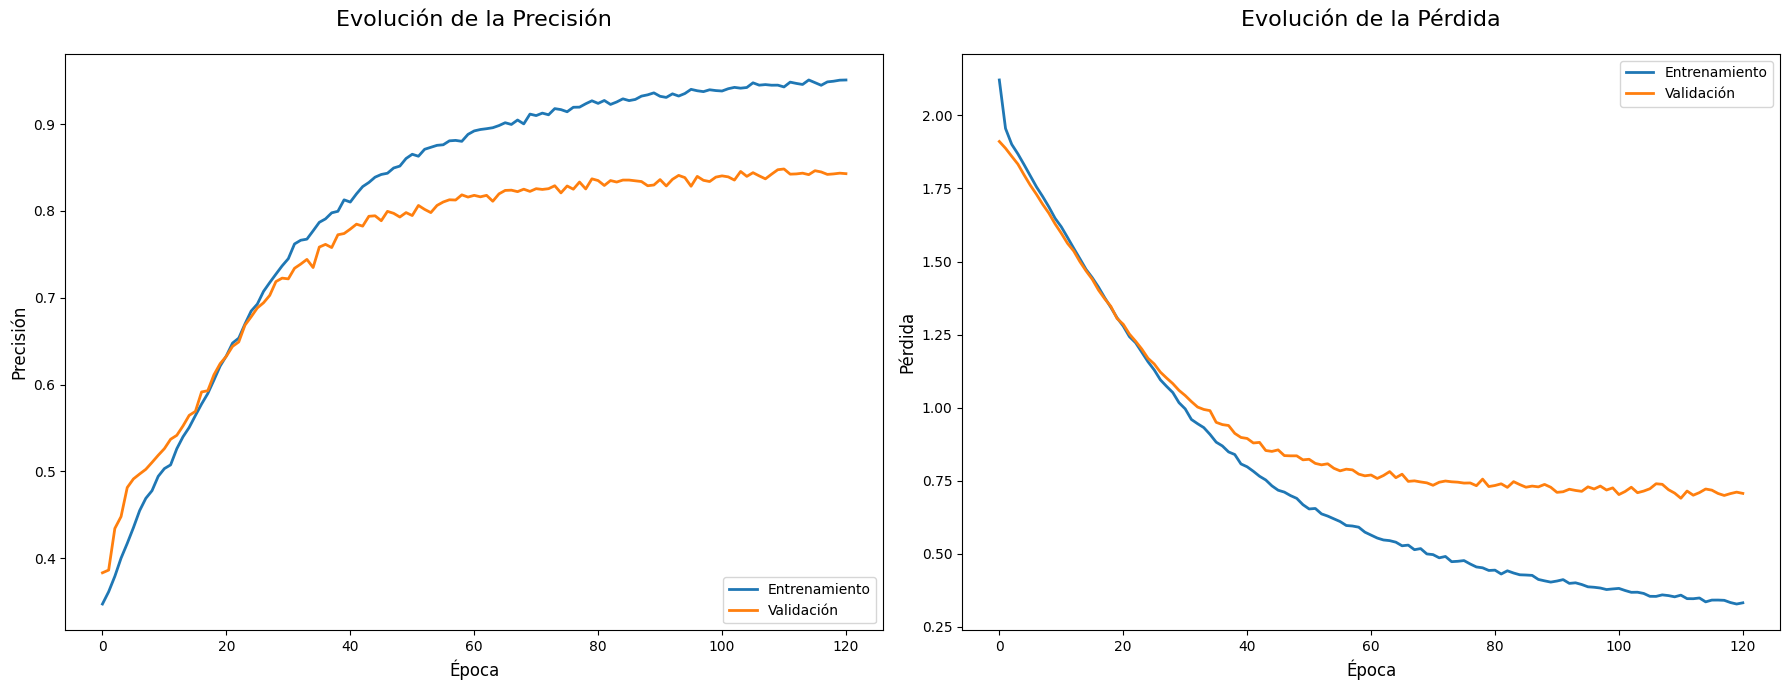

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo guardado exitosamente: chess_model.keras + metadatos
Modelo entrenado y guardado exitosamente
Modelo cargado exitosamente desde chess_model

Resultado del análisis:
Estilo detectado: Posicional
Apertura sugerida: Apertura Inglesa (A10)


In [ ]:
# Flujo principal corregido
try:
    # Inicialización y entrenamiento
    analyzer = ChessStyleAnalyzer()

    if analyzer.process_pgns():
        analyzer.train_model()  # Ya incluye early stopping mejorado

        # Guardado robusto del model
        analyzer.save_model("chess_model")
        print("model entrenado y guardado exitosamente")
    else:
        print("No se procesaron suficientes datos para entrenar")
        exit()

except Exception as e:
    print(f"Error durante entrenamiento: {str(e)}")
    exit()

# Carga segura del model
try:
    loaded_analyzer = ChessStyleAnalyzer.load_model("chess_model")
except Exception as e:
    print(f"Error al cargar el model: {str(e)}")
    exit()

# Análisis de partida con validaciones
pgn_example = """
[Event "Rated blitz game"]
[Site "https://lichess.org/p9pF1UIZ"]
[Date "2025.05.19"]
[White "Noc_sniper"]
[Black "bell505"]
[Result "1-0"]
[GameId "p9pF1UIZ"]
[UTCDate "2025.05.19"]
[UTCTime "03:47:42"]
[WhiteElo "2099"]
[BlackElo "2092"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B13"]
[Opening "Caro-Kann Defense: Panov Attack"]
[Termination "Normal"]
[Annotator "lichess.org"]

1. c4 { [%eval 0.12] [%clk 0:03:00] } 1... c6 { [%eval 0.23] [%clk 0:03:00] } 2. e4 { [%eval 0.1] [%clk 0:02:58] } 2... d5 { [%eval 0.0] [%clk 0:02:59] } 3. exd5 { [%eval 0.04] [%clk 0:02:58] } 3... cxd5 { [%eval 0.14] [%clk 0:02:59] } 4. d4 { [%eval 0.12] [%clk 0:02:58] } { B13 Caro-Kann Defense: Panov Attack } 4... Nf6 { [%eval 0.07] [%clk 0:02:57] } 5. Nf3 { [%eval 0.0] [%clk 0:02:58] } 5... Bg4 { [%eval 0.14] [%clk 0:02:55] } 6. Nc3 { [%eval 0.17] [%clk 0:02:57] } 6... e6 { [%eval 0.22] [%clk 0:02:53] } 7. Be3 { [%eval 0.14] [%clk 0:02:55] } 7... Be7 { [%eval 0.18] [%clk 0:02:50] } 8. Be2 { [%eval -0.1] [%clk 0:02:54] } 8... O-O { [%eval 0.03] [%clk 0:02:47] } 9. O-O { [%eval -0.17] [%clk 0:02:51] } 9... a6 { [%eval 0.07] [%clk 0:02:43] } 10. h3 { [%eval 0.11] [%clk 0:02:51] } 10... Bh5 { [%eval 0.16] [%clk 0:02:42] } 11. Ne5 { [%eval 0.01] [%clk 0:02:48] } 11... Bxe2 { [%eval 0.11] [%clk 0:02:40] } 12. Qxe2 { [%eval -0.03] [%clk 0:02:48] } 12... Nc6 { [%eval 0.17] [%clk 0:02:39] } 13. Rac1 { [%eval 0.21] [%clk 0:02:46] } 13... dxc4 { [%eval 0.42] [%clk 0:02:33] } 14. Rfd1 { [%eval 0.0] [%clk 0:02:45] } 14... Nd5 { [%eval 0.14] [%clk 0:02:27] } 15. Qxc4? { (0.14 → -1.16) Mistake. Nxc6 was best. } { [%eval -1.16] [%clk 0:02:40] } (15. Nxc6 bxc6) 15... Nxe3 { [%eval -1.2] [%clk 0:02:23] } 16. fxe3 { [%eval -1.37] [%clk 0:02:40] } 16... Rc8? { (-1.37 → -0.23) Mistake. Nxe5 was best. } { [%eval -0.23] [%clk 0:02:20] } (16... Nxe5 17. dxe5 Qb6 18. Qf4 Qxb2 19. Ne4 Rad8 20. Rf1 Rd7 21. a4 h6 22. Kh2) 17. Nxc6 { [%eval -0.52] [%clk 0:02:38] } 17... Rxc6 { [%eval -0.55] [%clk 0:02:19] } 18. Qb3 { [%eval -0.4] [%clk 0:02:37] } 18... b5?! { (-0.40 → 0.15) Inaccuracy. Rb6 was best. } { [%eval 0.15] [%clk 0:02:17] } (18... Rb6) 19. Ne4 { [%eval -0.35] [%clk 0:02:32] } 19... Qb6 { [%eval -0.23] [%clk 0:02:11] } 20. Qd3 { [%eval -0.19] [%clk 0:02:29] } 20... Rfc8 { [%eval -0.3] [%clk 0:02:09] } 21. Rxc6 { [%eval -0.32] [%clk 0:02:27] } 21... Qxc6 { [%eval -0.2] [%clk 0:02:04] } 22. Rd2?! { (-0.20 → -0.82) Inaccuracy. Nc5 was best. } { [%eval -0.82] [%clk 0:02:22] } (22. Nc5) 22... f5?! { (-0.82 → -0.15) Inaccuracy. Qc1+ was best. } { [%eval -0.15] [%clk 0:01:49] } (22... Qc1+ 23. Kf2 Qh1 24. Kf3 Bh4 25. Rc2 Rd8 26. Qe2 Qh2 27. Kg4 Be7 28. Kf3) 23. Nc3 { [%eval -0.56] [%clk 0:02:11] } 23... Bd6?! { (-0.56 → -0.01) Inaccuracy. Qc7 was best. } { [%eval -0.01] [%clk 0:01:46] } (23... Qc7 24. Rd1) 24. e4?? { (-0.01 → -2.08) Blunder. d5 was best. } { [%eval -2.08] [%clk 0:02:05] } (24. d5 Qe8 25. dxe6 Bc5 26. Nd5 Qxe6 27. Rc2 Bd6 28. Rxc8+ Qxc8 29. Kf2 Kf7) 24... fxe4?? { (-2.08 → -0.06) Blunder. b4 was best. } { [%eval -0.06] [%clk 0:01:35] } (24... b4 25. Nd1 fxe4 26. Qe3 h6 27. Re2 e5 28. Qb3+ Kh8 29. d5 Qc1 30. g3) 25. Nxe4 { [%eval -0.23] [%clk 0:02:05] } 25... Bf4 { [%eval -0.06] [%clk 0:01:29] } 26. Rd1 { [%eval -0.14] [%clk 0:01:54] } 26... h6? { (-0.14 → 1.10) Mistake. Qd5 was best. } { [%eval 1.1] [%clk 0:01:24] } (26... Qd5 27. Nc3) 27. g3? { (1.10 → -0.30) Mistake. Nf6+ was best. } { [%eval -0.3] [%clk 0:01:51] } (27. Nf6+ Kf7) 27... Bb8 { [%eval -0.15] [%clk 0:01:22] } 28. Nc5?! { (-0.15 → -1.20) Inaccuracy. d5 was best. } { [%eval -1.2] [%clk 0:01:45] } (28. d5 exd5 29. Qxd5+ Qxd5 30. Rxd5 Kf7 31. Rd2 Ke6 32. Kg2 Ke5 33. Nc3 Rc6) 28... Qd6?! { (-1.20 → -0.26) Inaccuracy. e5 was best. } { [%eval -0.26] [%clk 0:01:16] } (28... e5) 29. Kg2 { [%eval -0.28] [%clk 0:01:37] } 29... Ba7 { [%eval 0.0] [%clk 0:01:09] } 30. b4 { [%eval -0.34] [%clk 0:01:35] } 30... Rd8 { [%eval 0.0] [%clk 0:00:53] } 31. Qe4 { [%eval 0.0] [%clk 0:01:30] } 31... Rc8?! { (0.00 → 0.96) Inaccuracy. e5 was best. } { [%eval 0.96] [%clk 0:00:47] } (31... e5 32. Qf3 Bxc5 33. bxc5 Qc7 34. dxe5 Rxd1 35. Qxd1 Qxc5 36. Qd8+ Kh7 37. Qd6) 32. Rd2?! { (0.96 → 0.07) Inaccuracy. Re1 was best. } { [%eval 0.07] [%clk 0:01:18] } (32. Re1 a5 33. a3 Re8 34. h4 Bb8 35. Re3 Ba7 36. Kh3 axb4 37. axb4 Qf8) 32... Re8?! { (0.07 → 0.74) Inaccuracy. e5 was best. } { [%eval 0.74] [%clk 0:00:44] } (32... e5 33. Qxe5 Bxc5 34. Rc2 Qc6+ 35. d5 Qg6 36. Qe6+ Qxe6 37. dxe6 Kf8 38. Rxc5) 33. Re2 { [%eval 0.79] [%clk 0:01:12] } 33... Kf7 { [%eval 1.27] [%clk 0:00:42] } 34. Qb7+ { [%eval 1.08] [%clk 0:01:07] } 34... Re7 { [%eval 1.02] [%clk 0:00:40] } 35. Qf3+ { [%eval 0.92] [%clk 0:00:59] } 35... Kg8 { [%eval 0.84] [%clk 0:00:39] } 36. Qg4?! { (0.84 → 0.26) Inaccuracy. Qe4 was best. } { [%eval 0.26] [%clk 0:00:45] } (36. Qe4 a5) 36... Bxc5?! { (0.26 → 0.89) Inaccuracy. Qd5+ was best. } { [%eval 0.89] [%clk 0:00:35] } (36... Qd5+) 37. bxc5?! { (0.89 → 0.10) Inaccuracy. dxc5 was best. } { [%eval 0.1] [%clk 0:00:44] } (37. dxc5 Qd1 38. h4 Re8 39. Qe4 e5 40. Rf2 Qd8 41. Rc2 Qd1 42. c6 Rd8) 37... Qd5+ { [%eval 0.02] [%clk 0:00:33] } 38. Qe4 { [%eval 0.07] [%clk 0:00:43] } 38... Qc4?? { (0.07 → 3.49) Blunder. Kf8 was best. } { [%eval 3.49] [%clk 0:00:28] } (38... Kf8) 39. Qa8+? { (3.49 → 1.61) Mistake. c6 was best. } { [%eval 1.61] [%clk 0:00:36] } (39. c6 Qb4 40. d5 Qc5 41. dxe6 Qd6 42. Qc2 Qc7 43. Qc5 b4 44. h4 a5) 39... Kh7 { [%eval 1.92] [%clk 0:00:27] } 40. Qe4+ { [%eval 1.69] [%clk 0:00:34] } 40... Kg8?? { (1.69 → 3.98) Blunder. g6 was best. } { [%eval 3.98] [%clk 0:00:25] } (40... g6 41. h4) 41. Rc2?? { (3.98 → 0.17) Blunder. c6 was best. } { [%eval 0.17] [%clk 0:00:29] } (41. c6 Rc7 42. Qxe6+ Qxe6 43. Rxe6 Kf7 44. d5 Re7 45. Rd6 b4 46. Kf3 a5) 41... Qb4?? { (0.17 → 2.43) Blunder. Qd5 was best. } { [%eval 2.43] [%clk 0:00:22] } (41... Qd5) 42. c6 { [%eval 2.12] [%clk 0:00:27] } 42... Rc7?? { (2.12 → 5.72) Blunder. Qd6 was best. } { [%eval 5.72] [%clk 0:00:18] } (42... Qd6 43. Qe5 Qxe5 44. dxe5 Re8 45. Kf3 Kf7 46. Ke4 Rd8 47. h4 g6 48. Rf2+) 43. Qxe6+ { [%eval 4.99] [%clk 0:00:26] } 43... Kh8 { [%eval 5.8] [%clk 0:00:18] } 44. Qe5 { [%eval 5.56] [%clk 0:00:24] } 44... Qa4 { [%eval 6.52] [%clk 0:00:11] } 45. Rf2 { [%eval 6.42] [%clk 0:00:21] } 45... Rc8 { [%eval 6.49] [%clk 0:00:06] } 46. Qe6 { [%eval 5.99] [%clk 0:00:16] } 46... Rg8 { [%eval 7.34] [%clk 0:00:06] } 47. c7 { [%eval 7.29] [%clk 0:00:15] } 47... Qxd4 { [%eval 8.35] [%clk 0:00:03] } 48. c8=Q { [%eval 7.99] [%clk 0:00:13] } 48... Qd3? { (7.99 → Mate in 1) Checkmate is now unavoidable. Qd5+ was best. } { [%eval #1] [%clk 0:00:01] } (48... Qd5+ 49. Qxd5 Rxc8 50. Qf7 Rd8 51. Re2 Kh7 52. Re8 Rxe8 53. Qxe8 b4 54. Qe4+) 49. Qcxg8# { [%clk 0:00:12] } { White wins by checkmate. } 1-0
"""

result = loaded_analyzer.recommend_opening(pgn_example)

if result['status'] == 'success':
    print("\nResultado del análisis:")
    print(f"Estilo detectado: {result['style']}")
    print(f"Apertura sugerida: {result['opening']['name']} ({result['opening']['eco']})")
else:
    print(f"\nError: {result['message']}")